In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from yellowbrick.regressor import ResidualsPlot

In [2]:
df_month = pd.read_parquet('./cleaned_housing_month.parquet')

In [3]:
# Using Linear model on the log of averager price 
df_month['logged'] = df_month['average_price'].apply(np.log)

df_month['target'] = df_month.groupby('area')['logged'].shift(-1)


In [4]:
df_month = df_month.dropna()

In [5]:
df_month_model = df_month[['logged', 'houses_sold', 'target']]

X = df_month_model.drop('target', axis=1)
y = df_month_model.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [6]:
# Linear Regression model

lr = LinearRegression()
lr.fit(X_train, y_train)
ts_cv = TimeSeriesSplit(n_splits=3)

print(np.mean(cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=ts_cv )))

-0.011735196318358338


In [7]:
# Storing predictions of the model, exponentiating for interpretability
ypred_lr_log = lr.predict(X_test)
ypred_lr = np.exp(ypred_lr_log)

y_test_exp = np.exp(y_test)

In [8]:
# Testing the prediction
print(mean_absolute_error(y_test_exp, ypred_lr))        # MAE
print((mean_squared_error(y_test_exp, ypred_lr))**0.5)  # RMSE
print(r2_score(y_test_exp, ypred_lr))                   # R2 SCORE

4385.160941424855
7490.569553168016
0.9986929070307808


In [9]:
# Checking coefficients and intercept
cdf = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coefficients'])
intercept = lr.intercept_
print(cdf)
print(intercept)

             Coefficients
logged           0.998318
houses_sold      0.000021
0.020609348341068312


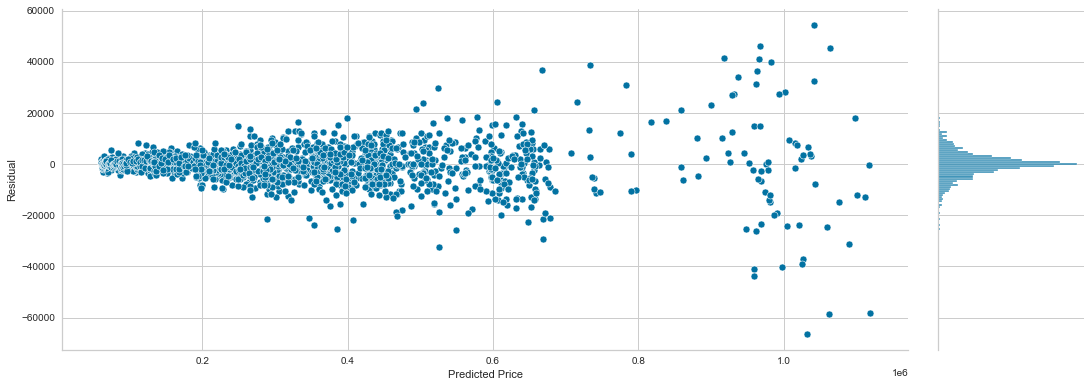

In [10]:
with sns.axes_style('whitegrid'):
    r = sns.jointplot(x=ypred_lr, y=y_test_exp-ypred_lr, height=12)
    r.set_axis_labels('Predicted Price', 'Residual')
    r.fig.set_figwidth(15)
    r.fig.set_figheight(6)
    r.ax_marg_x._visible=False